In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLarsIC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import nasdaqdatalink


# FTSE100 and House Price

# a

In [3]:
#importing datasets
house_price_df = pd.read_excel('Monthly.xls')
FTSE100_df = pd.read_csv('FTSE100.csv')

In [4]:
#setting the date as the index and extracting for the specified dates for house price
house_price_df.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
house_price_df = house_price_df.set_index('Date')
house_price_df = house_price_df.loc['1991-01-01':'2016-12-31']

In [5]:
#setting the date as the index and extracting for the specified dates for FTSE100 index
FTSE100_df['Date'] = pd.to_datetime(FTSE100_df['Date'])
FTSE100_df = FTSE100_df.set_index('Date')
FTSE100_df = FTSE100_df.loc['1991-01-01':'2016-12-31']
FTSE100_df = FTSE100_df.sort_index( ascending = True )
#resampling so that the dates in the dataset match
FTSE100_df = FTSE100_df.resample('MS').last()

In [6]:
#calculating the percentage change on the adjusted price and FTSE100
house_price_df['House Price return'] = house_price_df['Average House Price'].pct_change()
FTSE100_df['FTSE100 return'] = FTSE100_df['Adj Close'].pct_change()
monthly_return_df = house_price_df.merge(FTSE100_df, on='Date')[['House Price return','FTSE100 return']]
#dropping na values
monthly_return_df= monthly_return_df.dropna()

In [7]:
x = monthly_return_df['House Price return']
y = monthly_return_df['FTSE100 return']
res = linregress(x,y)

In [8]:
# y=mx+b -> linear regression model for one explanatory variable
m = res.slope
b = res.intercept
#the datapoints to be trained are prepared in a numpy array
fx = np.array([x.min(), x.max()])
# the linear regression model
fy = res.intercept + res.slope * fx
print("The Linear Regression model : y = ", res.slope,"x","+",res.intercept)

The Linear Regression model : y =  0.09324142754349966 x + 0.004047837686662456


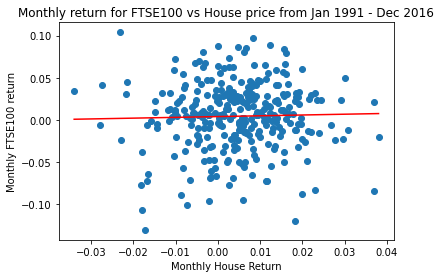

In [9]:
#scatter plotting the datapoints and line fitting the linear regression model
plt.scatter(x, y)
plt.plot(fx, fy, color = "red")
plt.xlabel('Monthly House Return')
plt.ylabel('Monthly FTSE100 return')
plt.title('Monthly return for FTSE100 vs House price from Jan 1991 - Dec 2016')
plt.show()

In [10]:
#correlation between monthly house return and FTSE100 index return
coorelation = monthly_return_df['FTSE100 return'].corr(monthly_return_df['House Price return'])
print("coorelation: ",coorelation)

coorelation:  0.026551295701909918


# b

In [11]:
# The variables have a very low positive correlation and it indicates
# that as one variable grows in size the other almost remains constant
# In addition to that since the slope is 0.093, it indicates that
# the monthly FTSE100 return is estimated to increase by 0.093 each month

# c

In [12]:
# Null Hypothesis - H0 : The FTSE100 return is going to stay the same 
# when the house price return increases (There is no relationship 
# between the two)

# Alternate Hypothesis - H0 : There is a linear relationship 
# between the FTSE100 and house price return)

# This is going to be a two-tailed test

# To find the pvalue we need to compute the t-statistics
# t =estimated slope/Standard error of estimated slope


alpha = 0.05
SE = res.stderr
estimated_slope = res.slope
t_test = estimated_slope/SE
dof = len(monthly_return_df)-2
p_val = scipy.stats.t.sf(abs(t_test), df = dof)
# since the above one is for one-tailed test, we need to multiply it by 2
p_value = 2*p_val

print("p value:", p_value)
# compare the P-value against alpha, the threshold
if(p_value<alpha):
    print("Null hypothesis is rejected")
    print("There is a relationship between the FTSE100 return and house price return")
else:
    print("Null hypothesis is accepted")
    print("FTSE100 return is going to stay the same when the house price return increases")


p value: 0.6409049000031651
Null hypothesis is accepted
FTSE100 return is going to stay the same when the house price return increases


# US College Acceptance

In [13]:
#setting the Institution as the index for ease of manipulation
college_df = pd.read_csv('College.csv')
college_df.rename(columns = {'Unnamed: 0':'Institution'}, inplace = True)
college_df = college_df.set_index('Institution')
college_df = college_df[['Apps', 'Enroll', 'Outstate', 'Top10perc' ,'Top25perc', 'Grad.Rate']]

# a

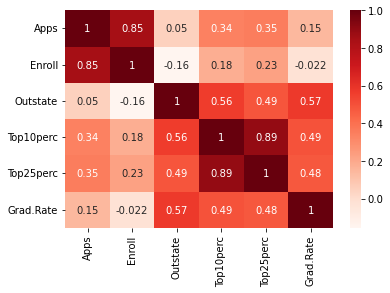

In [14]:
#correlation of the all variables
cor = college_df.corr()
cor
sns.heatmap(cor, annot=True, cmap = plt.cm.Reds)
plt.show()

In [15]:
#extracting the coorelation graduation rate has with the rest of the independent variables
cor.loc['Grad.Rate']

Apps         0.146755
Enroll      -0.022341
Outstate     0.571290
Top10perc    0.494989
Top25perc    0.477281
Grad.Rate    1.000000
Name: Grad.Rate, dtype: float64

# b

In [16]:
# an iterative forward stepwise feature selection function for linear regression
def forward_regression(X, y, threshold_in, verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included


In [45]:
#calling the forward step-wise selection for the college dataset to choose from the five specified variables
x_col = college_df[['Apps', 'Enroll', 'Outstate', 'Top10perc' ,'Top25perc']]
y_col = college_df[['Grad.Rate']]
X = forward_regression(x_col, y_col, 0.05)
X

y_col

C:\Users\Yamlak\AppData\Local\Temp\ipykernel_20132\622432094.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\Yamlak\AppData\Local\Temp\ipykernel_20132\622432094.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\Yamlak\AppData\Local\Temp\ipykernel_20132\622432094.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


,Grad.Rate
Institution,
Abilene Christian University,60
Adelphi University,56
Adrian College,54
Agnes Scott College,59
Alaska Pacific University,15
...,...
Worcester State College,40
Xavier University,83
Xavier University of Louisiana,49


In [18]:
# modelling and fitting the linear regression model for the variables selected through forward-stepwise selection
X_col = college_df[X]
reg_lin = LinearRegression()
reg_lin.fit(X_col, y_col)
print('y = ',reg_lin.feature_names_in_[0],'*', reg_lin.coef_[0,0],'+',reg_lin.feature_names_in_[1],'*', reg_lin.coef_[0,1] ,'+',reg_lin.intercept_[0])


y =  Outstate * 0.0018961105550138657 + Top25perc * 0.22547388327806267 + 33.085969109225715


# c

In [19]:
#the useful variables selceted from forward step-wise selection
X

['Outstate', 'Top25perc']

# d

In [20]:
# variable selection using the bayesian information criteria
reg_lin_bic = LassoLarsIC(criterion='bic', normalize=False)
reg_lin_bic.fit(x_col,y_col)
print(reg_lin_bic.coef_)
print(reg_lin_bic.feature_names_in_)
# since the top10perc coefficient is 0, we can omit that and use the
# remaining 4 variables for prediction
x_col

[ 0.00082806 -0.00293584  0.00186158  0.          0.17922103]
['Apps' 'Enroll' 'Outstate' 'Top10perc' 'Top25perc']


c:\Users\Yamlak\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Apps,Enroll,Outstate,Top10perc,Top25perc
Institution,,,,,
Abilene Christian University,1660,721,7440,23,52
Adelphi University,2186,512,12280,16,29
Adrian College,1428,336,11250,22,50
Agnes Scott College,417,137,12960,60,89
Alaska Pacific University,193,55,7560,16,44
...,...,...,...,...,...
Worcester State College,2197,543,6797,4,26
Xavier University,1959,695,11520,24,47
Xavier University of Louisiana,2097,695,6900,34,61


In [21]:

model = sm.OLS(y_col, x_col).fit() #using 5 variables
print('BIC using the 5 variables:',model.bic)
model2 = sm.OLS(y_col, X_col).fit() #using 2 variables - found by forward-selection
print('BIC using the variable selected by forward stepwise method:',model2.bic)
#comapring the two BIC's the one with the smallest BIC value is preferable as it indicates that it has less complexity

BIC using the 5 variables: 6519.454819969878
BIC using the variable selected by forward stepwise method: 6607.147126042169


# e

In [22]:
#fitting the three models found using forward-step wise selection, BIC selection and the 5-variables
reg_lin_using_5 = LinearRegression()
reg_lin_using_5.fit(x_col, y_col)

x_col_bic = college_df[['Apps', 'Enroll', 'Outstate','Top25perc']]
reg_lin_bic_selection = LinearRegression()
reg_lin_bic_selection.fit(x_col_bic, y_col)

predicted_selected = pd.DataFrame(reg_lin.predict(X_col))
mape_selected = mean_absolute_percentage_error(y_col,predicted_selected[0] )

predicted_using_5 = reg_lin_using_5.predict(x_col)
mape_using_5 = mean_absolute_percentage_error(y_col, pd.DataFrame(predicted_using_5)[0])

predicted_bic = reg_lin_bic_selection.predict(x_col_bic)
mape_bic = mean_absolute_percentage_error(y_col,pd.DataFrame(predicted_bic)[0])

#calculating the accuracy of the 3 models from their MAPE
print('Accuracy using selected features through forward stepwise : ',(1-mape_selected)*100,'%')
print('Accuracy using all 5 features : ',(1-mape_using_5)*100,'%')
print('Accuracy using features selected using BIC : ',(1-mape_bic)*100,'%')


Accuracy using selected features through forward stepwise :  80.78792435620574 %
Accuracy using all 5 features :  80.94871181821806 %
Accuracy using features selected using BIC :  80.92862073922343 %


In [23]:
# comapring the accuracy of the three models, the model with five predictors have the highest
# accuracy than the rest.

# f

In [24]:
# Using the most accurate model, which is the one with 5 predictors
# predicting the graduation rate for Carnegie Mellon University

cmu_outstate = x_col.loc['Carnegie Mellon University'].Outstate
cmu_top25perc = x_col.loc['Carnegie Mellon University'].Top25perc
cmu_apps = x_col.loc['Carnegie Mellon University'].Apps
cmu_enroll = x_col.loc['Carnegie Mellon University'].Enroll
cmu_top10 = x_col.loc['Carnegie Mellon University'].Top10perc

x1 = reg_lin_using_5.coef_[0,0]
x2 = reg_lin_using_5.coef_[0,1]
x3 = reg_lin_using_5.coef_[0,2]
x4 = reg_lin_using_5.coef_[0,3]
x5 = reg_lin_using_5.coef_[0,4]
b = reg_lin_using_5.intercept_[0]

# the linear regression model in equation
cmu_rate_predicted = cmu_apps*x1 + cmu_enroll*x2 + cmu_outstate*x3 + cmu_top10*x4 + cmu_top25perc*x5 + b
print("The predicted graduation rate for CMU using the most accurate model is :",cmu_rate_predicted)

#Alternatively we can check by passing the value to be predicted to the model 
reg_lin_using_5.predict([x_col.loc['Carnegie Mellon University']])[0,0]

The predicted graduation rate for CMU using the most accurate model is : 89.20112305346854


c:\Users\Yamlak\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


89.20112305346855

# Air Transportation and Passengers Analysis for Ehiopia

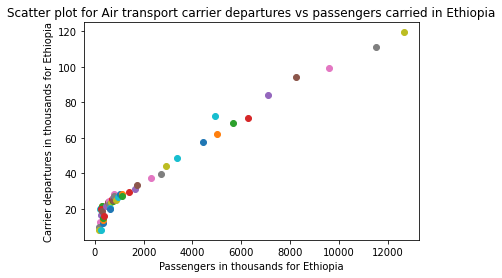

In [25]:
#reading data from file
carrier_departures =pd.read_excel('API_IS.AIR.DPRT_DS2_en_excel_v2_4523479.xls', skiprows = 3)
passengers_carried =pd.read_excel('API_IS.AIR.PSGR_DS2_en_excel_v2_4676827.xls', skiprows = 3)
#indexing by country
passengers_carried = passengers_carried.set_index('Country Name')
carrier_departures = carrier_departures.set_index('Country Name')
# select data for ethiopia
passengers_eth = passengers_carried.loc[['Ethiopia']]
carriers_Departure_eth = carrier_departures.loc[['Ethiopia']]
#scatter plot avialable data points
for i in range(4,65):
    plt.scatter(passengers_eth.iloc[:,i]/1000, carriers_Departure_eth.iloc[:,i]/1000)
    #divided the values by 1000 as the numbers are very large values
plt.xlabel('Passengers in thousands for Ethiopia')
plt.ylabel('Carrier departures in thousands for Ethiopia')
plt.title('Scatter plot for Air transport carrier departures vs passengers carried in Ethiopia')
plt.show()

In [26]:
#extract the necessary records and transposing them for ease of manipulation for passengers dataset
passengers_eth_df = passengers_eth.iloc[:, 3:64].T
passengers_eth_df.rename(columns = { 'Ethiopia':'Air transport, passengers carried'}, inplace = True)
#indexing by year
passengers_eth_df.columns.name = 'Year'

#extract the necessary records and transposing them for ease of manipulation for carrier departure
carriers_Departure_eth_df = carriers_Departure_eth.iloc[:,3:64].T
#indexing by year
carriers_Departure_eth_df.columns.name = 'Year'
carriers_Departure_eth_df.rename(columns = { 'Ethiopia':'Air transport, registered carrier departures'}, inplace = True)

passengers_eth_df = passengers_eth_df.dropna()
carriers_Departure_eth_df = carriers_Departure_eth_df.dropna()

# Correlation of the two variables
corr = carriers_Departure_eth_df['Air transport, registered carrier departures'].corr(passengers_eth_df['Air transport, passengers carried'])
print("The correlation coefficent is: ", corr)


The correlation coefficent is:  0.9873138138807313


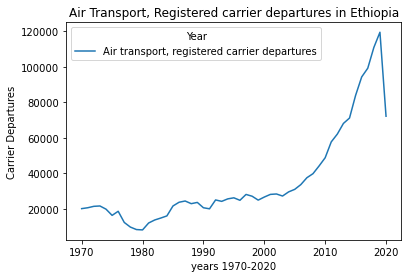

In [27]:
#timeseries plot for carrier departure
carriers_Departure_eth_df.plot()
plt.xlabel('years 1970-2020')
plt.ylabel('Carrier Departures')
plt.title('Air Transport, Registered carrier departures in Ethiopia')
plt.show()


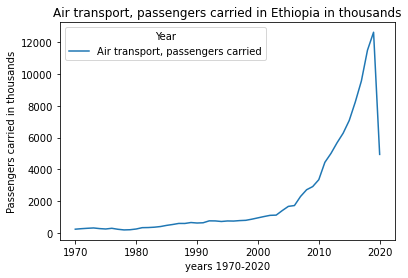

In [28]:
#timeseries plot for passengers carried
(passengers_eth_df/1000).plot()
plt.xlabel('years 1970-2020')
plt.ylabel('Passengers carried in thousands')
plt.title('Air transport, passengers carried in Ethiopia in thousands')
plt.show()

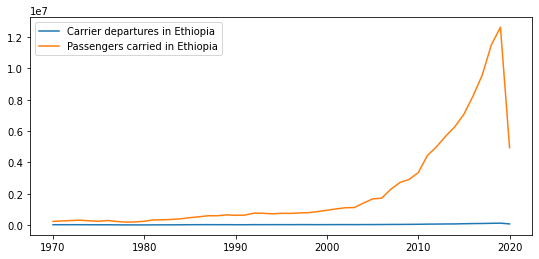

In [29]:
#timeseries plot for passengers carried and Carrier departures in a single graph to compare visually
fig, ax=plt.subplots(figsize=(9, 4))
carriers_Departure_eth_df.plot(ax=ax)
passengers_eth_df.plot(ax=ax)
plt.legend(['Carrier departures in Ethiopia', 'Passengers carried in Ethiopia'])
plt.show()


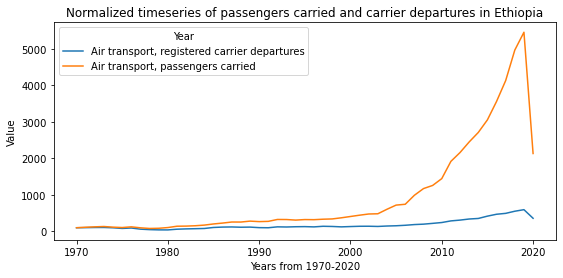

In [30]:
#normalizing the datapoints as the two dataframes have significantly large difference
normalized_passenger_df = (passengers_eth_df / (passengers_eth_df.head(1).values[0,0]))*100
normalized_carriers_Departure_df = (carriers_Departure_eth_df/(carriers_Departure_eth_df.head(1).values[0,0]))*100

#plotting normalized graph of the 2 variables
fig, ax=plt.subplots(figsize=(9, 4))
normalized_carriers_Departure_df.plot(ax=ax, label='Carriers departures')

(normalized_passenger_df).plot(ax=ax, label='Passengers carried in hundreds')
plt.xlabel('Years from 1970-2020')
plt.ylabel('Value')
plt.title('Normalized timeseries of passengers carried and carrier departures in Ethiopia')
plt.show()


In [31]:
air_transport_df = carriers_Departure_eth_df.merge(passengers_eth_df, right_index= True, left_index=True)
y = air_transport_df[['Air transport, registered carrier departures']]
X = air_transport_df[['Air transport, passengers carried']]

#model fitting for each timeseries
model = LinearRegression()
model.fit(X,y)

air_transport_df.index = pd.DatetimeIndex(air_transport_df.index)
air_transport_df

y1 = air_transport_df[['Air transport, registered carrier departures']]
y2 = air_transport_df[['Air transport, passengers carried']]

X = air_transport_df.index.year.values.reshape(-1,1)
#model fitting for each timeseries
model_1 = LinearRegression()
model_1.fit(X,y1)
#model fitting for each timeseries

model_2 = LinearRegression()
model_2.fit(X,y2)
#predicting for the two models(each dataset separately)
predicted_carrier_departures = model_1.predict(X)
predicted_passengers = model_2.predict(X)

air_transport_df['Predicted Carrier Departures'] = predicted_carrier_departures
air_transport_df['Predicted passengers'] = predicted_passengers

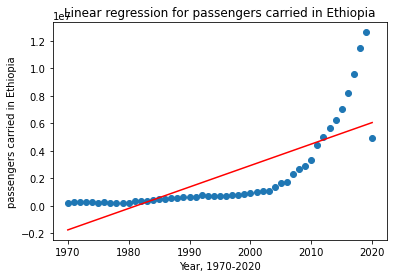

In [32]:
#plotting the datapoints in scatter and fitted linear regression for passengers carried
plt.plot(air_transport_df.index, air_transport_df['Predicted passengers'], color = "red")
plt.scatter(air_transport_df.index, y2)
plt.title('Linear regression for passengers carried in Ethiopia')
plt.xlabel('Year, 1970-2020')
plt.ylabel('passengers carried in Ethiopia')
plt.show()

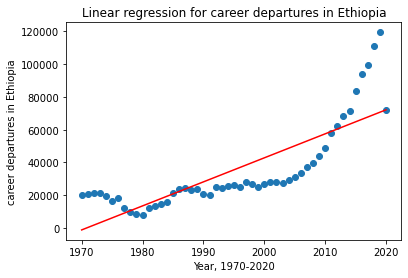

In [33]:
#plotting the datapoints in scatter and fitted linear regression for carrier departures
plt.plot(air_transport_df.index, air_transport_df['Predicted Carrier Departures'], color = "red")
plt.scatter(air_transport_df.index, y1)
plt.title('Linear regression for career departures in Ethiopia')
plt.xlabel('Year, 1970-2020')
plt.ylabel('career departures in Ethiopia')
plt.show()

In [34]:
#fitting new models using a natural logarithm function
model_3 = LinearRegression()
model_3.fit(X,np.log(y1))

model_4 = LinearRegression()
model_4.fit(X,np.log(y2))

# predicting using the log models
predicted_log_carrier_departures = model_3.predict(X)
predicted_log_passengers = model_4.predict(X)

air_transport_df['Predicted Carrier Departures (log)'] = predicted_log_carrier_departures
air_transport_df['Predicted passengers (log)'] = predicted_log_passengers



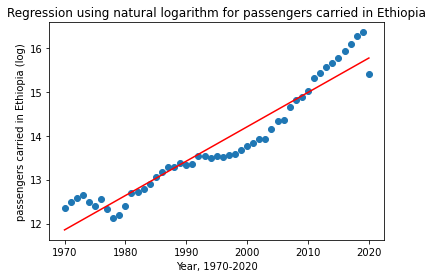

In [35]:
#plotting the datapoints in scatter and fitted linear regression for passengers carried (log)
plt.plot(air_transport_df.index, air_transport_df['Predicted passengers (log)'], color = "red")
plt.scatter(air_transport_df.index, np.log(y2))
plt.title('Regression using natural logarithm for passengers carried in Ethiopia')
plt.xlabel('Year, 1970-2020')
plt.ylabel('passengers carried in Ethiopia (log)')
plt.show()

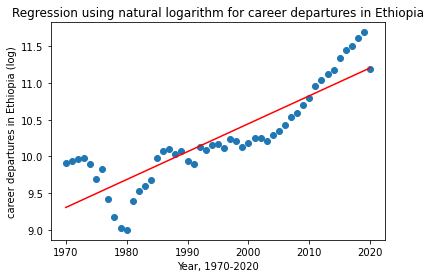

In [36]:
#plotting the datapoints in scatter and fitted linear regression for carrier departures(log)
plt.plot(air_transport_df.index, air_transport_df['Predicted Carrier Departures (log)'], color = "red")
plt.scatter(air_transport_df.index, np.log(y1))
plt.title('Regression using natural logarithm for career departures in Ethiopia')
plt.xlabel('Year, 1970-2020')
plt.ylabel('career departures in Ethiopia (log)')
plt.show()

In [37]:
#predicting using all the variables for the year 2021
#transforming the datapoint (year) to an array so that it can be passed to the model
year_2021= np.array([[2021]])
prediction_1 = model_1.predict(year_2021)[0,0]
print("predicted carrier departure in 2021 :", round(prediction_1))
prediction_2 = model_2.predict(year_2021)[0,0]
print("predicted passenger carried in 2021  :",round(prediction_2))
prediction_3 = math.exp(model_3.predict(year_2021)[0,0])
print("predicted carrier departure in 2021 using log :", round(prediction_3))
prediction_4 = model_4.predict(year_2021)[0,0]
print("predicted passenger carried in 2021 using log :", round(math.exp(prediction_4)))

predicted carrier departure in 2021 : 73642
predicted passenger carried in 2021  : 6217093
predicted carrier departure in 2021 using log : 76435
predicted passenger carried in 2021 using log : 7601122


# Unemployment Analysis in Israel

In [38]:
#imporing data from Nasdaq
api_key = 'Use your API Here'
nasdaqdatalink.ApiConfig.api_key = api_key
Unemp_rate = nasdaqdatalink.get("ODA/ISR_LUR")

In [39]:
#extracting for the specified dates
unempt_rate_data = Unemp_rate.loc['1980-12-31':'2013-12-31']
unempt_rate_data.index = pd.to_datetime(unempt_rate_data.index)

#setting the index as datetimeindex
unemp_df = unempt_rate_data.copy()
X = (pd.DatetimeIndex(unemp_df.index).year).values.reshape(-1,1)
y = unemp_df.Value.values
#fitting the model
model = LinearRegression()
model.fit(X,y)

y_pred = pd.DataFrame(model.predict(X), index= unemp_df.index)
y_pred.rename(columns = {0:'predicted'}, inplace = True)

df = y_pred.merge(unemp_df[['Value']], on = unemp_df.index )
df = df.rename(columns = {'key_0' : 'Date'}).set_index('Date')

#the slope and y intercept
model.coef_, model.intercept_

(array([0.11527777]), -221.4999193277311)

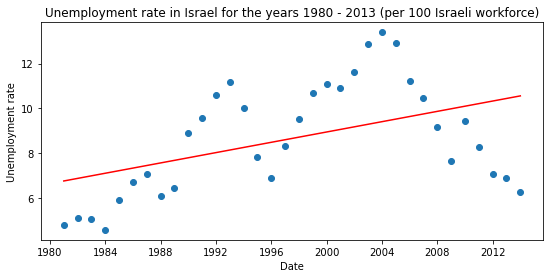

In [40]:
#plotting the datapoints in scatter and fitted linear regression for unemployement rate in israel
fig, ax=plt.subplots(figsize=(9, 4))
plt.plot(df.index, df['predicted'], color='red')
plt.scatter(df.index,df['Value'] )
plt.xlabel('Date')
plt.ylabel('Unemployment rate')
plt.title('Unemployment rate in Israel for the years 1980 - 2013 (per 100 Israeli workforce)')
plt.show()


In [41]:
#predicting unemployement rate in 2020
y_pred = pd.DataFrame(model.predict(X), index=unemp_df.index)
#changing the years format into datetime index so that it can be passed to the model
year_2020 = pd.DatetimeIndex(Unemp_rate['2020-12-31': '2020-12-31'].index).year.values.reshape(-1,1)

predicted_unemp_rate = model.predict(year_2020)
print("The unemployment rate predicted to be ",predicted_unemp_rate[0],"in the year 2020" )

The unemployment rate predicted to be  11.361174637127561 in the year 2020


In [42]:
#accuracy of the model using all available datapoints calculated from the MAPE
MAPE_model = mean_absolute_percentage_error(df['Value'], df['predicted'])
print("Accuracy of the model :", (1-MAPE_model)*100,'%')


Accuracy of the model : 76.28918444044366 %


In [43]:
#accuracy of the estimated unemployment rate during 2020 compared against the true value

MAPE_2020 = mean_absolute_percentage_error(Unemp_rate['2020-12-31':'2020-12-31'],predicted_unemp_rate)
print("Accuracy of the estimate for 2020 :", (1-MAPE_2020)*100,'%')


Accuracy of the estimate for 2020 : 94.67645530939635 %
